In [1]:
# This notebook produces the dataframe used for visualization in the report. 

import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'


In [2]:
nuc_adata_mouse = sc.read_h5ad('nuc_seqs_emb_mouse.h5ad')
aa_adata_mouse = sc.read_h5ad('aa_seqs_emb_mouse.h5ad')

# process nuc-seq embeddings (nt-emb)
# filtering out a small number of columns that have extreme values compared to remaining dimensions.
min_val, max_val = (-30, 30)
remove_idx = np.union1d(np.where(np.max(nuc_adata_mouse.X, axis=0) >= max_val)[0], np.where(np.min(nuc_adata_mouse.X, axis=0) <= min_val)[0])
keep = set(range(nuc_adata_mouse.X.shape[1])) - set(remove_idx)
nuc_adata_mouse = nuc_adata_mouse[:, list(keep)].copy()
print(f'Removed {remove_idx.size} dimensions with values outside range [{min_val}, {max_val}]')

# process aa-seq embeddings (esm3-emb)
aa_adata_mouse = aa_adata_mouse[aa_adata_mouse.obs['pass_filter'], :].copy()
aa_adata_mouse.obs.set_index("ensg_id", inplace=True)
aa_adata_mouse.obs.index.name = "ensg_id"

Removed 11 dimensions with values outside range [-30, 30]


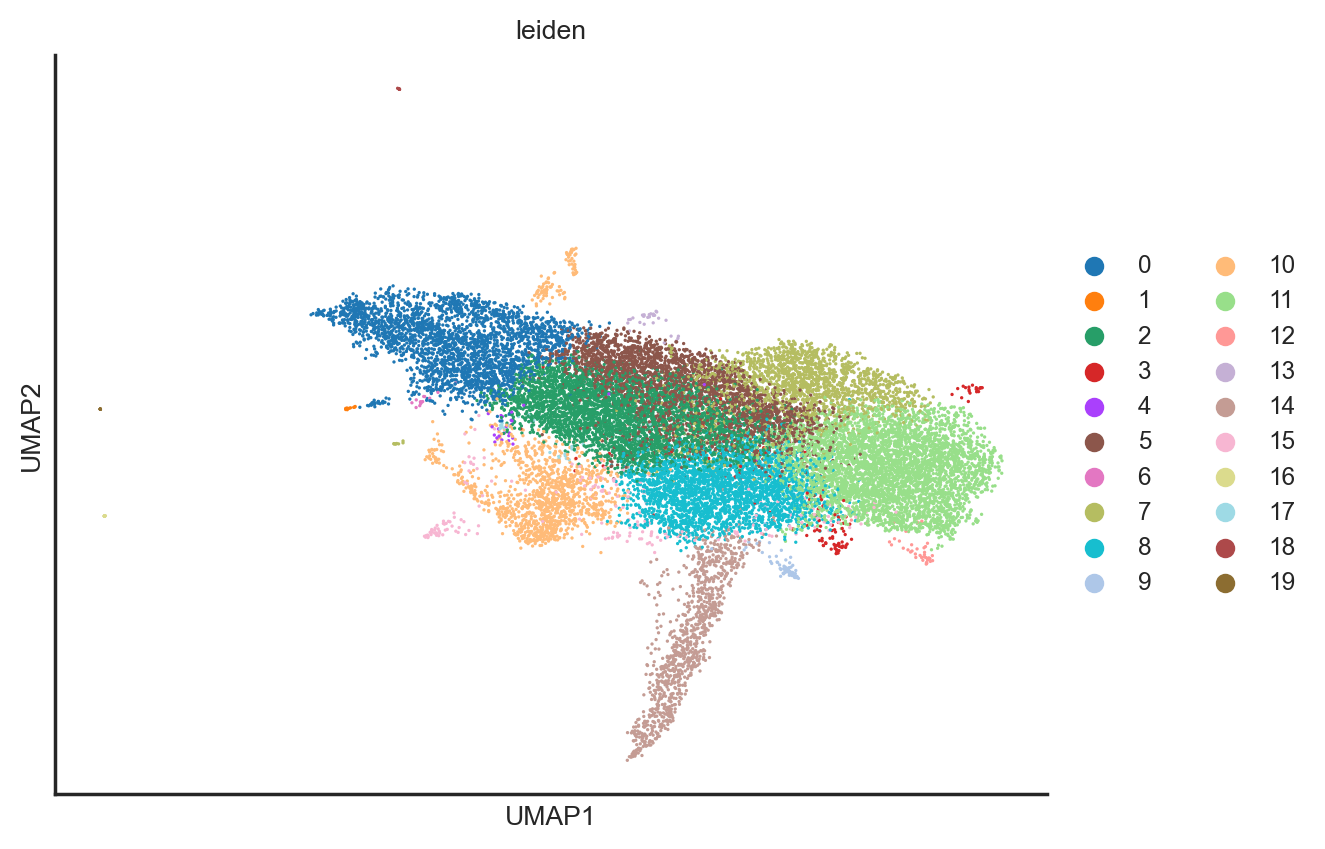

In [3]:
sc.pp.neighbors(nuc_adata_mouse, n_neighbors=25, use_rep="X")
sc.tl.leiden(nuc_adata_mouse, flavor="igraph", n_iterations=2, resolution=1.0)
sc.tl.umap(nuc_adata_mouse)
sc.pl.umap(nuc_adata_mouse, color=['leiden'])

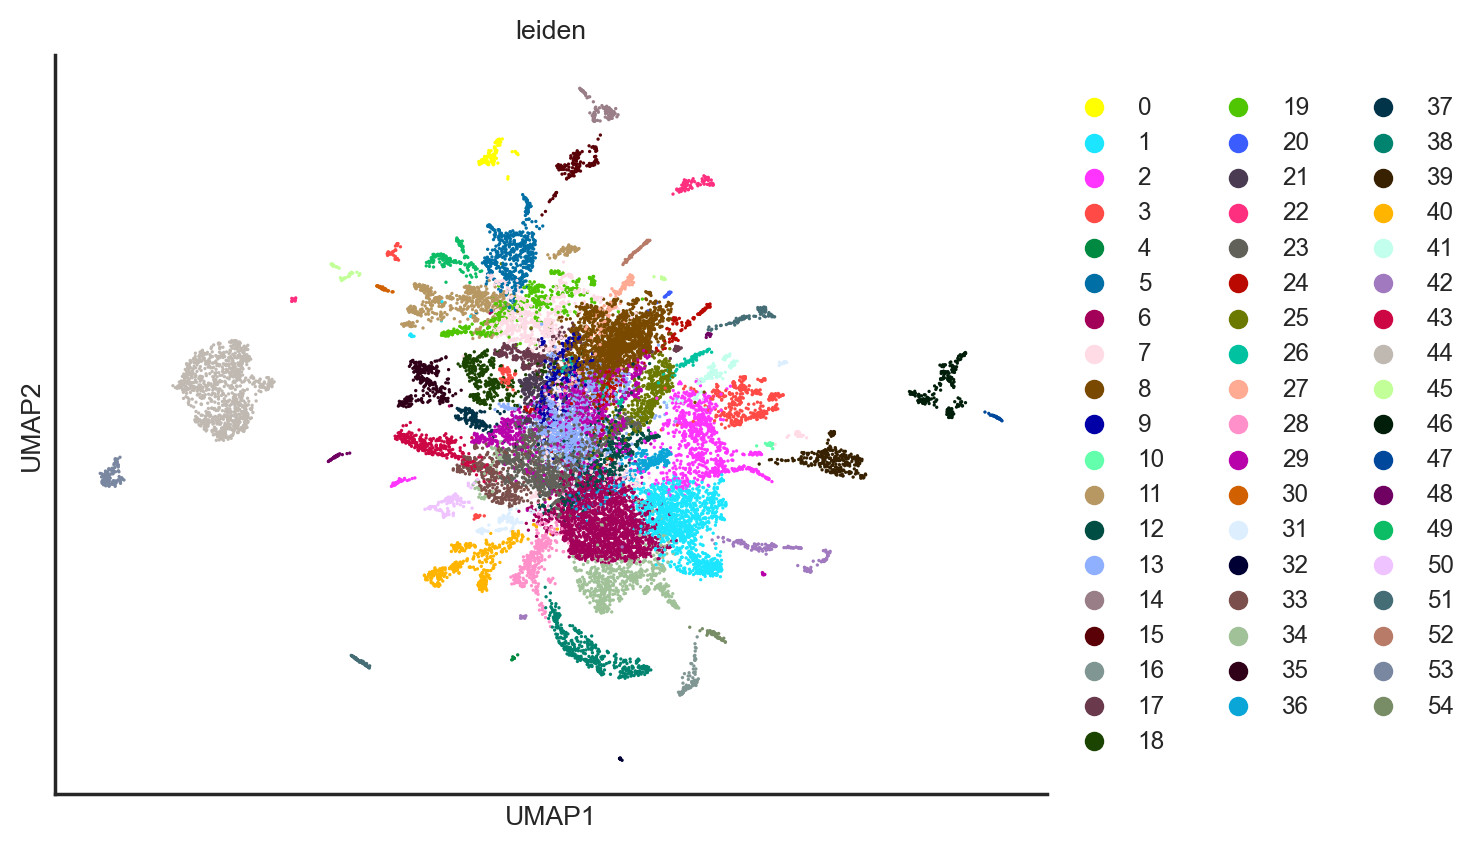

In [4]:
sc.pp.neighbors(aa_adata_mouse, n_neighbors=25, use_rep="X")
sc.tl.leiden(aa_adata_mouse, flavor="igraph", n_iterations=2, resolution=1.0)
sc.tl.umap(aa_adata_mouse)
sc.pl.umap(aa_adata_mouse, color=['leiden'])

In [5]:
# relabel joint categories by abundance. category is -1 when mmidas labels disagree across views. 
mmidas = pd.read_csv("mouse_multimodal_mmidas_numC_27_cscore_0.92.csv")
mmidas = mmidas[['ensg_id', 'aa_category', 'nuc_category']].copy()
mmidas = mmidas.set_index('ensg_id')
mmidas = mmidas.rename(columns={'aa_category': 'esm3_cat', 'nuc_category': 'nt_cat'})
mmidas['esm3_cat'] = mmidas['esm3_cat'].astype('category')
mmidas['nt_cat'] = mmidas['nt_cat'].astype('category')

mmidas['mmidas-joint_'] = [-1] * len(mmidas)
mmidas['mmidas-joint'] = [-1] * len(mmidas)
for new_cat, og_cat in enumerate(mmidas['esm3_cat'].value_counts().index):
    mmidas.loc[(mmidas['nt_cat'] == og_cat) & (mmidas['esm3_cat'] == og_cat), 'mmidas-joint'] = new_cat
    mmidas.loc[(mmidas['nt_cat'] == og_cat) & (mmidas['esm3_cat'] == og_cat), 'mmidas-joint_'] = og_cat

In [6]:
display(mmidas['mmidas-joint'].value_counts().sort_index().to_frame().head(5))

,count
mmidas-joint,
-1,2639
0,4549
1,3642
2,2177
3,1486


In [7]:
display(mmidas.head(5))

,esm3_cat,nt_cat,mmidas-joint_,mmidas-joint
ensg_id,,,,
ENSMUSG00000076500.3,28,28,28,18
ENSMUSG00000090395.2,23,23,23,2
ENSMUSG00000090765.2,23,23,23,2
ENSMUSG00000094491.3,28,23,-1,-1
ENSMUSG00000096580.2,28,28,28,18


In [8]:
# Create a merged dataframe `overview_mouse` with the following columns:
# the values will are obtained from merging `nuc_adata_mouse`, `aa_adata_mouse` and `mmidas` dataframes
#   - `ensg_id`
#   - `gene_symbol`
#   - `nt-umap-0`
#   - `nt-umap-1`
#   - `aa-umap-0`
#   - `aa-umap-1`
#   - `leiden-esm3` (convert to cat)
#   - `leiden-nt` (convert to cat)
#   - `mmidas-joint` (convert to cat)

# Get common ensg_ids across all dataframes
nuc_ensg = set(nuc_adata_mouse.obs.index)
aa_ensg = set(aa_adata_mouse.obs.index) 
mmidas_ensg = set(mmidas.index)

# Find intersection of all sets
common_ensg = nuc_ensg.intersection(aa_ensg).intersection(mmidas_ensg)
df = pd.DataFrame(common_ensg, columns=['ensg_id'])
df = df.set_index('ensg_id')

In [9]:
# slice and then reorder
nuc_adata_df = nuc_adata_mouse[nuc_adata_mouse.obs_names.isin(df.index)].copy()
nuc_adata_df = nuc_adata_df[df.index]

aa_adata_df = aa_adata_mouse[aa_adata_mouse.obs_names.isin(df.index)].copy()
aa_adata_df = aa_adata_df[df.index]

mmidas_df = mmidas.loc[df.index]

assert(np.all(nuc_adata_df.obs.index==df.index))
assert(np.all(aa_adata_df.obs.index==df.index))
assert(np.all(mmidas_df.index==df.index))

In [10]:
display(aa_adata_df.obs.tail(2))
display(nuc_adata_df.obs.tail(2))
display(mmidas_df.tail(2))

,gene_symbol,enst_id,nuc_seq_length,aa_seq_length,nuc_aa_seq_ratio,chromosome,start,end,strand,nuc_seq,aa_seq,pred_score,safety_check,pass_filter,leiden
ensg_id,,,,,,,,,,,,,,,
ENSMUSG00000038224.13,Serpinf2,ENSMUST00000043696,2192,491.0,4.464358,GRCm39:11,75322562.0,75330327.0,-1.0,GAGAACACCGTGTGCTGCGTGTGCTGCGCTAAGAAGCCTGAAGAGG...,MALLRGLLVLSLSCLQGPCFTFSPVSAVDLPGQQPVSEQAQQKLPL...,0.0,False,True,52
ENSMUSG00000062822.9,4833420G17Rik,ENSMUST00000224312,3406,639.0,5.330203,GRCm39:13,119599320.0,119622653.0,1.0,CTCGGTGCGGGAGGCTCCAACTGCTGCCTCGCTTTGTGTTTTGTTT...,MGMAAEVRMVLYEDDSVQVHYACGSTLQLSPCGSEFLFEKALPPST...,0.0,False,True,6


,gene_symbol,enst_id,nuc_seq_length,aa_seq_length,nuc_aa_seq_ratio,chromosome,start,end,strand,nuc_seq,aa_seq,leiden
ensg_id,,,,,,,,,,,,
ENSMUSG00000038224.13,Serpinf2,ENSMUST00000043696,2192,491.0,4.464358,GRCm39:11,75322562.0,75330327.0,-1.0,GAGAACACCGTGTGCTGCGTGTGCTGCGCTAAGAAGCCTGAAGAGG...,MALLRGLLVLSLSCLQGPCFTFSPVSAVDLPGQQPVSEQAQQKLPL...,7
ENSMUSG00000062822.9,4833420G17Rik,ENSMUST00000224312,3406,639.0,5.330203,GRCm39:13,119599320.0,119622653.0,1.0,CTCGGTGCGGGAGGCTCCAACTGCTGCCTCGCTTTGTGTTTTGTTT...,MGMAAEVRMVLYEDDSVQVHYACGSTLQLSPCGSEFLFEKALPPST...,2


,esm3_cat,nt_cat,mmidas-joint_,mmidas-joint
ensg_id,,,,
ENSMUSG00000038224.13,9,9,9,0
ENSMUSG00000062822.9,50,50,50,1


In [11]:
df['gene_symbol'] = nuc_adata_df.obs['gene_symbol'].values
df["leiden-nt"] = nuc_adata_df.obs['leiden'].values
df["leiden-esm3"] = aa_adata_df.obs['leiden'].values
df["mmidas-joint"] = mmidas_df['mmidas-joint'].values
df["nt-umap-0"] = nuc_adata_df.obsm['X_umap'][:, 0].copy()  
df["nt-umap-1"] = nuc_adata_df.obsm['X_umap'][:, 1].copy()
df["aa-umap-0"] = aa_adata_df.obsm['X_umap'][:, 0].copy()
df["aa-umap-1"] = aa_adata_df.obsm['X_umap'][:, 1].copy()

In [12]:
df.head()

,gene_symbol,leiden-nt,leiden-esm3,mmidas-joint,nt-umap-0,nt-umap-1,aa-umap-0,aa-umap-1
ensg_id,,,,,,,,
ENSMUSG00000018566.15,Slc2a4,8,3,9,10.830853,0.346162,14.341636,4.835434
ENSMUSG00000040888.12,Gfer,14,24,-1,11.152143,-4.010281,7.149468,4.560211
ENSMUSG00000078235.4,Fam43b,2,23,1,11.687284,1.119307,6.526958,0.824544
ENSMUSG00000037601.12,Nme1,11,8,-1,14.691661,-1.600978,9.567575,8.384590
ENSMUSG00000047642.16,D930020B18Rik,7,6,1,13.537884,2.808056,6.777545,0.177699


In [13]:
df.to_csv("mouse_df.csv")